# 1. Introduction





## 1.1 Overview

Netflix is the dominant company in the streaming entertainment industry. It has over 190 subscribers, making it one of the world’s largest entertainment services. Its content varies from original shows, movies, and network TV. According to Investopedia’s compelling analysis, as of 2019, an estimated 21.9 million American households will switch to streaming services such as Netflix, and this was expected to reach 34.9 million by 2023. The rating and genre of a movie/TV show usually have a high influence on users’ preferences. By understanding the composition of these two major factors, this project aims to uncover the popular trend of current entertainment streaming services and construct models for multi-label classification.


We will use the dataset “Netflix Movies and TV Shows” found on Kaggle. This dataset contains 6234 objects and 12 attributes as of January 2020. The attributes include show_id, type (movie or TV show), title, director, cast, country, date_added, release_year, rating, duration, listed_in, and description.

## 1.2 Related Work
Database: https://www.kaggle.com/shivamb/netflix-shows 


One Vs. All: https://scikit-learn.org/stable/modules/multiclass.html


Motivation: https://www.investopedia.com/articles/investing/060815/how-netflix-changing-tv-industry.asp


LSTM Model: https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/


GloVe: https://nlp.stanford.edu/projects/glove/



## 1.3 Initial Questions
1. In what month(s), the number of new releases is comparatively greater than in other months? Does every year follow the same pattern? 
2. What are the factors that might affect our classification model? 
3. What features are needed in the final classification model? 



# 2. Import Dataset & Library Supports

In [ ]:
# import libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter


In [56]:
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

file = "/content/drive/Shared drives/Principle of Data Science CSCE 320/netflix_titles.csv"
df = pd.read_csv(file)
df.head(5)

Mounted at /content/drive


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Exploitory Data Analysis (EDA)

The EDA below seeks to help us understand the dataset better. The two types of content, movie and TV Show, will be analyzed separately. 

## 3.1 Movie vs. TV Show


Number of Movie vs. TV Show

[4265, 1969]

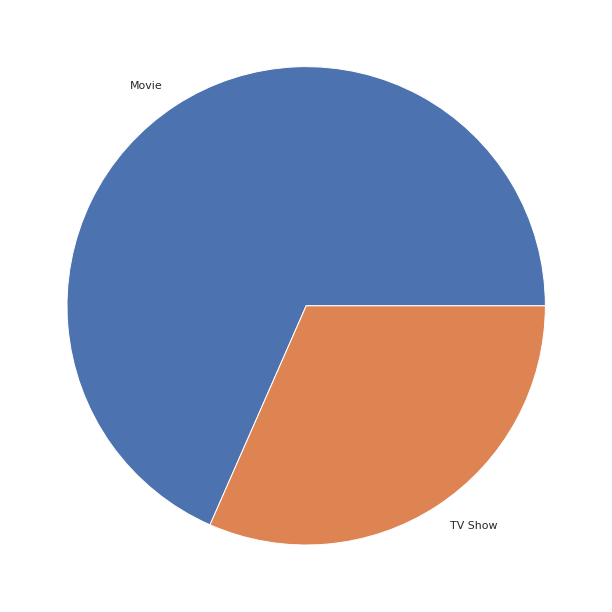

In [58]:
count = df.groupby(by='type').agg('count').show_id
label = ['Movie', 'TV Show']
freq = [count[0], count[1]]
plt.pie(freq, labels=label)
freq


This pie chart shows the count of movies and TV Shows in the dataset. There are a total of 4265 movies and 1969 TV Shows.

## 3.2 Movie

Most & Least Content Creating Countries

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Numer of Movies Created in Each Country')

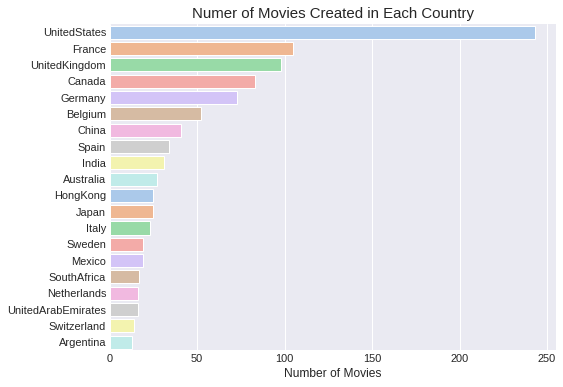

In [59]:
df_movie = df.loc[df['type'] == 'Movie']

countries={}
df_movie['country']=df_movie['country'].fillna('Unknown')
cou=list(df_movie['country'])

for i in cou:
    i=list(i.split(','))
    if len(i)==1:
        if i in list(countries.keys()):
            countries[i]+=1
        else:
            countries[i[0]]=1
    else:
        for j in i:
            if j in list(countries.keys()):
                countries[j]+=1
            else:
                countries[j]=1

countries_plot={}
for country,no in countries.items():
    country=country.replace(' ','')
    if country in list(countries_plot.keys()):
        countries_plot[country]+=no
    else:
        countries_plot[country]=no
        
countries_plot={k: v for k, v in sorted(countries_plot.items(), key=lambda item: item[1], reverse= True)}

plt.figure(figsize=(8,6))
plt.style.use('seaborn-darkgrid')
fig = sns.barplot(x=list(countries_plot.values())[0:20],y=list(countries_plot.keys())[0:20], palette='pastel')
fig.set_xlabel('Number of Movies')
fig.set_title('Numer of Movies Created in Each Country', size=15)

This horizontal bar chart shows the number of movies created in each country. As shown, the United States is the country with the most movie production.

Number of Releases in Each Year

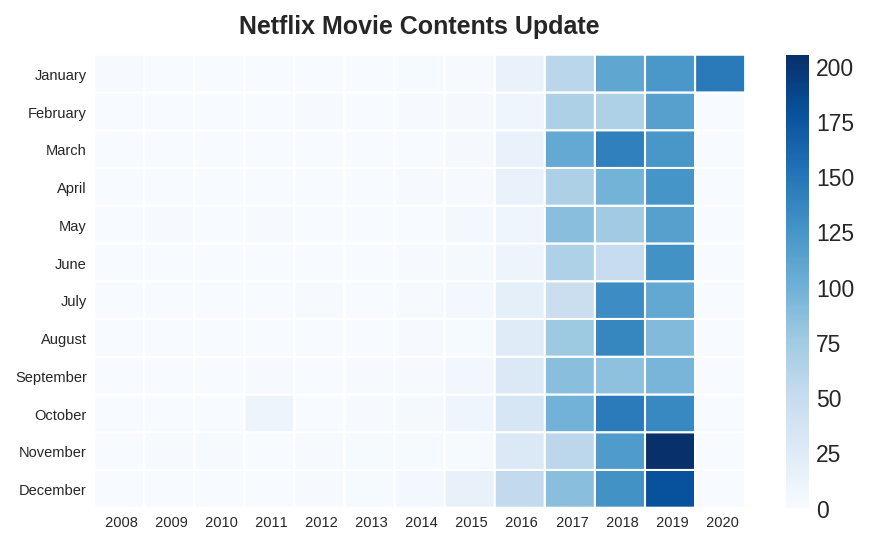

In [60]:
date = df_movie[['date_added']].dropna()
dates = date['date_added'].str.split(',', expand=True)
date['year'] = dates[1]
date['month'] = dates[0].str.split(' ', expand=True)[0]

month = ['December', 'November', 'October', 'September', 'August', 'July', 'June', 'May', 'April', 'March', 'February', 'January']
movie = date.groupby('year')['month'].value_counts().unstack().fillna(0)[month].T
plt.figure(figsize=(7, 4), dpi=150)
plt.pcolor(movie, cmap='Blues', edgecolors='white', linewidths=1) # heatmap
plt.xticks(np.arange(0.5, len(movie.columns), 1), movie.columns, fontsize=7)
plt.yticks(np.arange(0.5, len(movie.index), 1), movie.index, fontsize=7)

plt.title('Netflix Movie Contents Update', fontsize=12, fontweight='bold', position=(0.50, 1.0+0.02))
cbar = plt.colorbar()
plt.show()


This heat map shows the amount of movie content added to Netflix each month for the years 2008 to 2020. If a producer wants to release a movie onto Netflix, he or she should avoid the later months as they are more competitive with more content release.

Rating Analysis

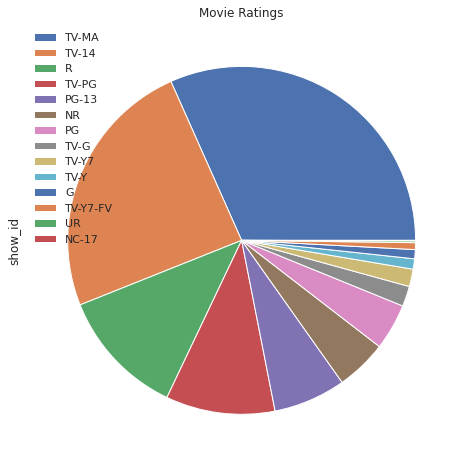

In [61]:
plt.figure(figsize=(10,8))
sns.set(style="whitegrid")

ratings = df_movie.groupby(by='rating').agg('count').show_id 
ratings = ratings.sort_values(ascending=False)
ratings.plot(kind='pie', title='Movie Ratings', labels=None)
labels = ['TV-MA', 'TV-14', 'R', 'TV-PG', 'PG-13', 'NR', 'PG', 'TV-G', 'TV-Y7', 'TV-Y', 'G', 'TV-Y7-FV', 'UR', 'NC-17']
plt.legend(labels)

This bar chart shows the number of movies in each rating category. The TV-MA category, which is the category with mature content, has the most movies.

Movie Duration Analysis

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


[Text(0.5, 0, 'Duration in Minutes'),
 Text(0.5, 1.0, 'Movie Duration Density Graph')]

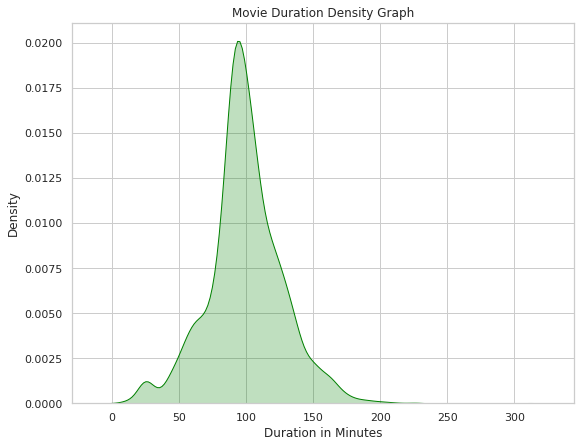

In [62]:
df_movie['duration_int']=df_movie['duration'].apply(lambda x:x.split(' ')[0]).astype(int)
plt.figure(figsize=(9,7))
ax2 = sns.kdeplot(data=df_movie['duration_int'], color = 'green', shade=True)
ax2.set(xlabel='Duration in Minutes', title='Movie Duration Density Graph')

This density plot shows the duration of movies in minutes. As shown, most movies are concentrated in the range of 90 min to 120 min.

Word Cloud

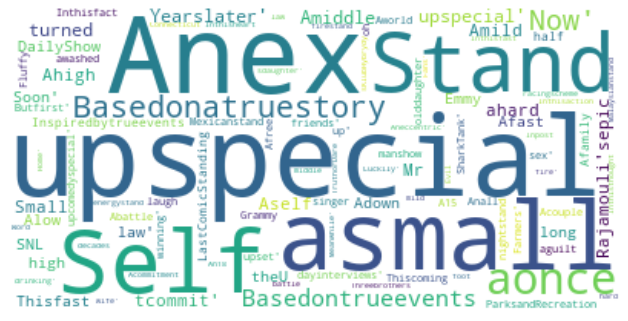

In [63]:
describe_movie=list(df_movie['description'])
des_movie=[]

for i in describe_movie:
    i=list(i.split(','))
    for j in i:
        des_movie.append(j.replace(' ',''))
d_movie=Counter(des_movie)

text_movie = list(set(des_movie))
stopwords = set(STOPWORDS)
stopwords.update(['year'])
plt.rcParams['figure.figsize'] = (11, 11)
wordcloud_movie = WordCloud(stopwords=stopwords,max_words=100,background_color="white").generate(str(text_movie))

plt.imshow(wordcloud_movie,interpolation="bilinear")
plt.axis("off")
plt.show()

This is a word cloud for words that appear in movie descriptions. Stopwords are removed using the defined STOPWORDS in WordCloud. The word 'year' is added as a stopword because it appears frequently but does not provide meaning. We chose to do a word cloud because we wanted to see what words appear most in movie descriptions. This may be important in future data analysis and classification. 

## 3.3 TV Show

Most & Least Content Creating Countries

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Numer of TV Shows Created in Each Country')

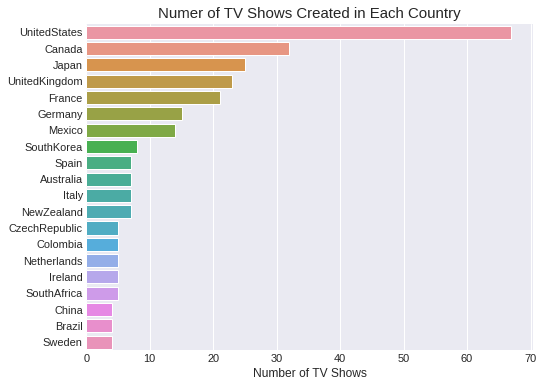

In [64]:
df_TV = df.loc[df['type'] == 'TV Show']

countries_tv={}
df_TV['country']=df_TV['country'].fillna('Unknown')
cou_tv=list(df_TV['country'])
for i in cou_tv:
    i=list(i.split(','))
    if len(i)==1:
        if i in list(countries_tv.keys()):
            countries_tv[i]+=1
        else:
            countries_tv[i[0]]=1
    else:
        for j in i:
            if j in list(countries_tv.keys()):
                countries_tv[j]+=1
            else:
                countries_tv[j]=1

countries_fin_tv={}
for country,no in countries_tv.items():
    country=country.replace(' ','')
    if country in list(countries_fin_tv.keys()):
        countries_fin_tv[country]+=no
    else:
        countries_fin_tv[country]=no
        
countries_fin_tv={k: v for k, v in sorted(countries_fin_tv.items(), key=lambda item: item[1], reverse= True)}

plt.figure(figsize=(8,6))
plt.style.use('seaborn-darkgrid')
fig = sns.barplot(x=list(countries_fin_tv.values())[0:20],y=list(countries_fin_tv.keys())[0:20])
fig.set_xlabel('Number of TV Shows')
fig.set_title('Numer of TV Shows Created in Each Country', size=15)

This horizontal bar chart shows the number of TV Shows created in each country. As shown, the United States is the country with the most TV Show production.

Number of Releases in Each Year

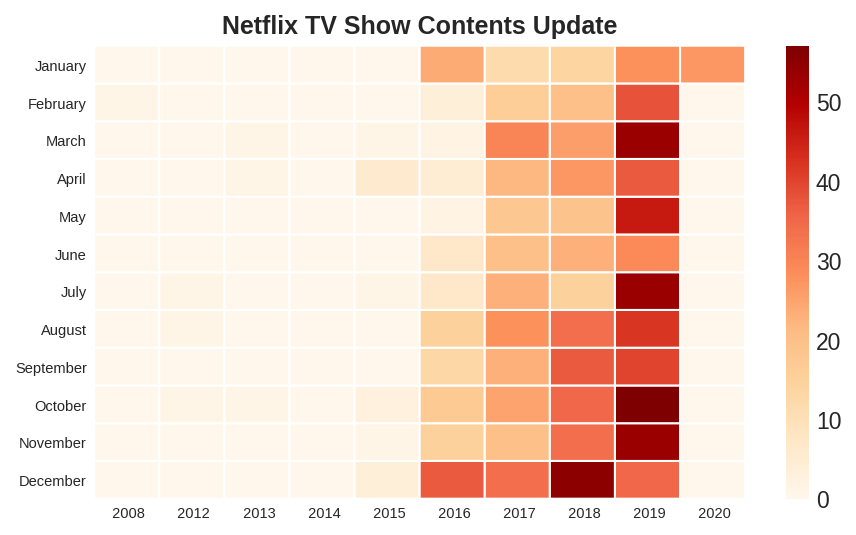

In [65]:
date = df_TV[['date_added']].dropna()
dates = date['date_added'].str.split(',', expand=True)
date['year'] = dates[1]
date['month'] = dates[0].str.split(' ', expand=True)[0]

month = ['December', 'November', 'October', 'September', 'August', 'July', 'June', 'May', 'April', 'March', 'February', 'January']
tv = date.groupby('year')['month'].value_counts().unstack().fillna(0)[month].T
plt.figure(figsize=(7, 4), dpi=150)
plt.pcolor(tv, cmap='OrRd', edgecolors='white', linewidths=1) # heatmap
plt.xticks(np.arange(0.5, len(tv.columns), 1), tv.columns, fontsize=7)
plt.yticks(np.arange(0.5, len(tv.index), 1), tv.index, fontsize=7)

plt.title('Netflix TV Show Contents Update', fontsize=12, fontweight='bold', position=(0.50, 1.0))
cbar = plt.colorbar()
plt.show()

This heat map shows the amount of TV Show content added to Netflix each month for the years 2008 to 2020. If a producer wants to release a TV Show onto Netflix, he or she should avoid the months with deep color as they are more competitive with more content release.

Rating Analysis

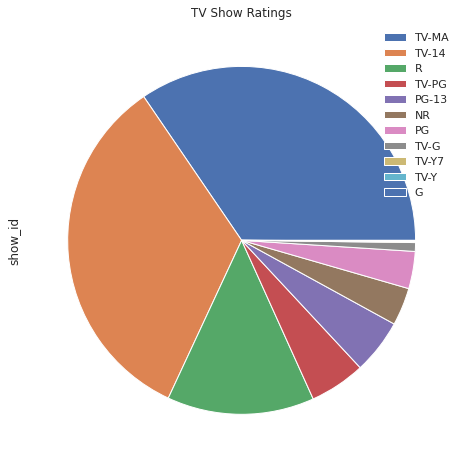

In [66]:
plt.figure(figsize=(10,8))
sns.set(style="whitegrid")

ratings = df_TV.groupby(by='rating').agg('count').show_id 
ratings = ratings.sort_values(ascending=False)
ratings.plot(kind='pie', title='TV Show Ratings', labels=None)
labels = ['TV-MA', 'TV-14', 'R', 'TV-PG', 'PG-13', 'NR', 'PG', 'TV-G', 'TV-Y7', 'TV-Y', 'G', 'TV-Y7-FV', 'UR', 'NC-17']
plt.legend(labels)

This bar chart shows the number of TV Shows in each rating category. The TV-MA category, which is the category with mature content, has the most TV Shows.

TV Shows Season Analysis

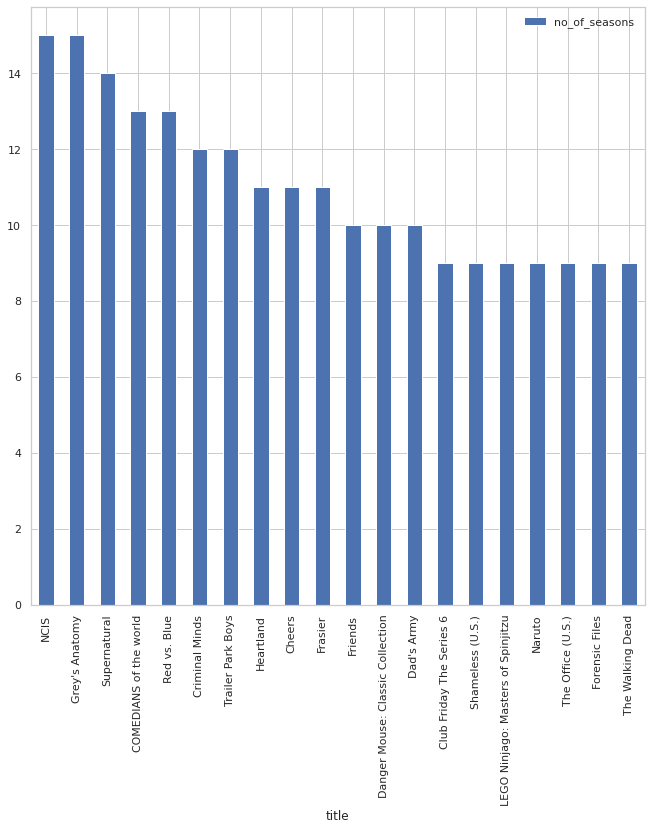

In [67]:
features=['title','duration']
durations= df_TV[features].copy()

durations['no_of_seasons']=durations['duration'].str.replace(' Season','')

durations['no_of_seasons']=durations['no_of_seasons'].str.replace('s','')

durations['no_of_seasons']=durations['no_of_seasons'].astype(str).astype(int)

t=['title','no_of_seasons']
top=durations[t]

top=top.sort_values(by='no_of_seasons', ascending=False)

top20=top[0:20]
top20.plot(kind='bar',x='title', y='no_of_seasons' )

The pie chart shows the TV Shows with most seasons on Netflix. NCIS, Supernatural, and Grey's Anatomy are the top three. The shows with the most seasons are all popular shows, so there may be a correlation between seasons and popularity. This may be a potential area for analysis.

Word Cloud

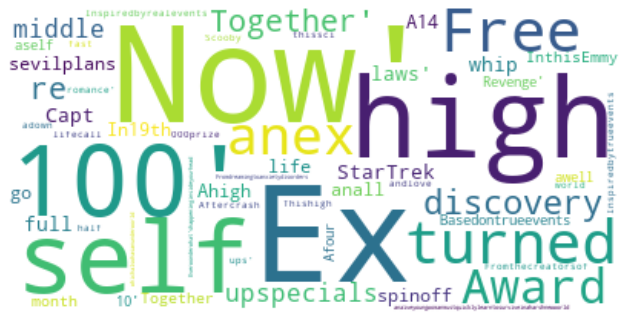

In [68]:
describe_tv=list(df_TV['description'])
des_tv=[]

for i in describe_tv:
    i=list(i.split(','))
    for j in i:
        des_tv.append(j.replace(' ',''))
d_tv=Counter(des_tv)

text_tv = list(set(des_tv))
stopwords = set(STOPWORDS)
stopwords.update(['year', 'Dr'])
plt.rcParams['figure.figsize'] = (11, 11)
wordcloud_tv = WordCloud(stopwords=stopwords,background_color="white").generate(str(text_tv))

plt.imshow(wordcloud_tv,interpolation="bilinear")
plt.axis("off")
plt.show()

This is a word cloud for words that appear in TV Show descriptions. Stopwords are removed using the defined STOPWORDS in WordCloud. The bigger the word, the more appearances it has made in descriptions.



# 4. Processing Data

## Data Processing

For data processing, we first dropped all the cases where the 'listed_in" or "description" columns contain NULL Values. Then, we created multiple binary columns base on the "Listed in" column in the dataset and each binary column will indicate if the video belongs to a corresponding label using 1s and 0s.

We also decided to drop all the TV data because We had only 59 samples of them in the dataset after dropping the NUll values. Then we splited
data into train and testing, set description column to be the feature and binary columns to be the labels.

 Finally, we vectorized the description column using the bag of words method. We tried 3 different methods (Count, Hash, Tfid), and Tfid turned out to be the best method for our tasks.

  For Neural Network we implemented word embedding instead of using the traditional bag of words approach.



In [69]:
def getLabelTable(label):
    newTable =  pd.DataFrame(label.tolist(),columns = ["category_1", "category_2","category_3"])
    category_1_genres = newTable.category_1.unique()
    category_2_genres = newTable.category_2.unique()
    category_3_genres = newTable.category_3.unique()

    genres = np.concatenate([category_1_genres, category_2_genres, category_3_genres]).tolist() 
    genres = list(dict.fromkeys(genres))
    genres = [x for x in genres if x is not None] 
    
    returnTable = pd.concat([newTable,pd.DataFrame(columns = list(genres))])
    returnTable.fillna(0,inplace=True)
    row = 0
    all_listed_in = label.tolist()
    for listed_in in all_listed_in:
      for topic in listed_in:
        returnTable.loc[row,topic] = 1
      row+=1
    return returnTable

In [70]:
# Drop row with NA value
df.dropna(inplace=True)

# Split into two dataset (Movie and TV show)
tvData = df[df['type'] == 'TV Show']
movieData = df[df['type'] == 'Movie']

# Split data into features and label
featuresColumn = ['description']
labelColumn = ["listed_in"]

# TV data
tvX = tvData[featuresColumn]
tvY = tvData[labelColumn]

# movieData
movieX = movieData[featuresColumn]
movieY = movieData[labelColumn]
# Drop row with NA value
df.dropna(inplace=True)

# Split into two dataset (Movie and TV show)
tvData = df[df['type'] == 'TV Show']
movieData = df[df['type'] == 'Movie']

# Split data into features and label
featuresColumn = ['description']
labelColumn = ["listed_in"]

# TV data
tvX = tvData[featuresColumn]
tvY = tvData["listed_in"].apply(lambda x: x.split(', '))
tvY = getLabelTable(tvY)

# movieData
movieX = movieData[featuresColumn]
movieY = movieData["listed_in"].apply(lambda x: x.split(', '))
movieY = getLabelTable(movieY)
movieY.head(5)

,category_1,category_2,category_3,Children & Family Movies,Comedies,International Movies,Stand-Up Comedy,Action & Adventure,Cult Movies,Horror Movies,Dramas,Documentaries,Independent Movies,Movies,Thrillers,Classic Movies,Music & Musicals,Sci-Fi & Fantasy,Anime Features,Romantic Movies,LGBTQ Movies,Sports Movies,Faith & Spirituality
0,Children & Family Movies,Comedies,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Comedies,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,International Movies,Sci-Fi & Fantasy,Thrillers,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,Stand-Up Comedy,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Action & Adventure,Thrillers,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## 4.1 Split Training & Testing Sets

In [71]:
from sklearn.model_selection import train_test_split
tv_X_train, tv_X_test, tv_y_train, tv_y_test = train_test_split(tvX, tvY, test_size=0.33, random_state=42)
movie_X_train, movie_X_test, movie_y_train, movie_y_test = train_test_split(movieX, movieY, test_size=0.33, random_state=42)

print(movie_y_test[movie_y_test.columns[4]])


2129    0
1744    0
3172    1
2845    0
1691    0
       ..
518     0
1820    0
767     1
3616    1
421     0
Name: Comedies, Length: 1214, dtype: int64


## 4.2 Format & Vectorize Texting Fields

In [72]:
# Convert 'date_added' to Date time
df['date_added'] =  pd.to_datetime(df['date_added'])
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize Description 
def TfidVect(dataset):
  vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
  vectorizer.fit(dataset)

  return vectorizer

def CountVect(dataset):
  vectorizer = CountVectorizer()
  vectorizer.fit(dataset)
  return vectorizer

def HashVect(dataset):
  vectorizer = HashVectorizer()
  vectorizer.fit(dataset)
  return vectorizer


movieVectorizer = TfidVect(movie_X_train["description"])

movie_X_train_vectorized = movieVectorizer.transform(movie_X_train["description"])
movie_X_test_vectorized = movieVectorizer.transform(movie_X_test["description"])

print("Vectorization Complete")

Vectorization Complete


# 5. Model Construction

Our initial approach to the classification was to build one vs rest classifiers for each label and then combined all the classifiers to construct a multi-label classifier after doing cross-validation on those independent classifiers. We will test this approach to logistic regression, random forest, and SVM.

MODEL 1


We first tested our approach to logistic regression, and it turned to have a poor performance on AUC-ROC

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score




logistic_Model =  OneVsRestClassifier(LogisticRegression())
accraucy = 0
roc_auc = 0
result = []
print(movie_y_train.columns)
for columnName in movie_y_train.columns[3:]:
    logistic_Model.fit(movie_X_train_vectorized,movie_y_train[columnName])
    accraucy += logistic_Model.score(movie_X_test_vectorized,movie_y_test[columnName])
    prediction = logistic_Model.predict(movie_X_test_vectorized)
    result.append(prediction.tolist())
    roc_auc += roc_auc_score(movie_y_test[columnName],prediction)


print("ROC_AUC:",roc_auc/len(movie_y_train.columns[3:]))
logistic_auc_roc = roc_auc/len(movie_y_train.columns[3:])



Index(['category_1', 'category_2', 'category_3', 'Children & Family Movies',
       'Comedies', 'International Movies', 'Stand-Up Comedy',
       'Action & Adventure', 'Cult Movies', 'Horror Movies', 'Dramas',
       'Documentaries', 'Independent Movies', 'Movies', 'Thrillers',
       'Classic Movies', 'Music & Musicals', 'Sci-Fi & Fantasy',
       'Anime Features', 'Romantic Movies', 'LGBTQ Movies', 'Sports Movies',
       'Faith & Spirituality'],
      dtype='object')
ROC_AUC: 0.5179840778823559


In [74]:
value1 = pd.DataFrame(result).T.values.tolist()
value2 = movie_y_test[movie_y_test.columns[3:]].values.tolist()
count = 0
for v1,v2 in zip(value1,value2):
    if(v1 == v2):
        count += 1
count/len(value1)
lr_acc = count/len(value1)

MODEL 2


Then, we tested our approach to the Random Forest classifier, hoping for a better result. Unfortunately, the performance of the model is still lower than our expectations.

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
  

logistic_Model =  OneVsRestClassifier(RandomForestClassifier())
accraucy = 0
roc_auc = 0
result = []
print(movie_y_train.columns)
for columnName in movie_y_train.columns[3:]:
    logistic_Model.fit(movie_X_train_vectorized,movie_y_train[columnName])
    accraucy += logistic_Model.score(movie_X_test_vectorized,movie_y_test[columnName])
    prediction = logistic_Model.predict(movie_X_test_vectorized)
    result.append(prediction.tolist())
    roc_auc += roc_auc_score(movie_y_test[columnName],prediction)


print("ROC_AUC:",roc_auc/len(movie_y_train.columns[3:]))
rf_auc_roc = roc_auc/len(movie_y_train.columns[3:])

Index(['category_1', 'category_2', 'category_3', 'Children & Family Movies',
       'Comedies', 'International Movies', 'Stand-Up Comedy',
       'Action & Adventure', 'Cult Movies', 'Horror Movies', 'Dramas',
       'Documentaries', 'Independent Movies', 'Movies', 'Thrillers',
       'Classic Movies', 'Music & Musicals', 'Sci-Fi & Fantasy',
       'Anime Features', 'Romantic Movies', 'LGBTQ Movies', 'Sports Movies',
       'Faith & Spirituality'],
      dtype='object')
ROC_AUC: 0.5333207228764028


In [76]:
value1 = pd.DataFrame(result).T.values.tolist()
value2 = movie_y_test[movie_y_test.columns[3:]].values.tolist()
count = 0
for v1,v2 in zip(value1,value2):
    if(v1 == v2):
        count += 1
count/len(value1)
rf_acc = count/len(value1)

MODEL 3

Finally, we tested our method on a higher-order classification method (SVM), and it turned out to be the same as the previous two models


In [77]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score


logistic_Model =  OneVsRestClassifier(LinearSVC())
accraucy = 0
roc_auc = 0
result = []
print(movie_y_train.columns)
for columnName in movie_y_train.columns[3:]:
    logistic_Model.fit(movie_X_train_vectorized,movie_y_train[columnName])
    accraucy += logistic_Model.score(movie_X_test_vectorized,movie_y_test[columnName])
    prediction = logistic_Model.predict(movie_X_test_vectorized)
    result.append(prediction.tolist())
    roc_auc += roc_auc_score(movie_y_test[columnName],prediction)


print("ROC_AUC:",roc_auc/len(movie_y_train.columns[3:]))
svm_auc_roc = roc_auc/len(movie_y_train.columns[3:])

Index(['category_1', 'category_2', 'category_3', 'Children & Family Movies',
       'Comedies', 'International Movies', 'Stand-Up Comedy',
       'Action & Adventure', 'Cult Movies', 'Horror Movies', 'Dramas',
       'Documentaries', 'Independent Movies', 'Movies', 'Thrillers',
       'Classic Movies', 'Music & Musicals', 'Sci-Fi & Fantasy',
       'Anime Features', 'Romantic Movies', 'LGBTQ Movies', 'Sports Movies',
       'Faith & Spirituality'],
      dtype='object')
ROC_AUC: 0.563356145710423


In [78]:
value1 = pd.DataFrame(result).T.values.tolist()
value2 = movie_y_test[movie_y_test.columns[3:]].values.tolist()
count = 0
for v1,v2 in zip(value1,value2):
    if(v1 == v2):
        count += 1
count/len(value1)
svm_acc = count/len(value1)

MODEL 4

In [79]:
glove_file = open('/content/drive/Shared drives/Principle of Data Science CSCE 320/glove.6B.100d.txt', encoding="utf8")

In [80]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import zeros
from numpy import array
from numpy import asarray

# Data Processing
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(movie_X_train['description'])
sequences = tokenizer.texts_to_sequences(movie_X_train['description'])
X_train = pad_sequences(sequences, padding='post', maxlen=200)
sequences = tokenizer.texts_to_sequences(movie_X_test['description'])
X_test = pad_sequences(sequences, padding='post', maxlen=200)

y_train = movie_y_train[movie_y_train.columns[3:]].values
y_test = movie_y_test[movie_y_test.columns[3:]].values

vocab_size = len(tokenizer.word_index) + 1
embeddings_dictionary = dict()

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector



In [82]:
most_common_cat = pd.DataFrame()
most_common_cat['cat'] = movieY.columns[3:]
most_common_cat['count'] = movieY.iloc[:,3:].sum().values
most_common_cat.sort_values(['count'], inplace=True, ascending=False)
most_common_cat.reset_index(inplace=True, drop=True)
most_common_cat['class_weight'] = len(most_common_cat) / most_common_cat['count']

categories = most_common_cat['cat'].values

class_weight = {}
for index, label in enumerate(categories):
    class_weight[index] = most_common_cat[most_common_cat['cat'] == categories]['class_weight'].values[0]
most_common_cat.head(10)    

,cat,count,class_weight
0,International Movies,1722,0.011614
1,Dramas,1572,0.012723
2,Comedies,1058,0.018904
3,Action & Adventure,583,0.034305
4,Independent Movies,545,0.036697
5,Thrillers,382,0.052356
6,Romantic Movies,363,0.055096
7,Children & Family Movies,322,0.062112
8,Documentaries,306,0.065359
9,Horror Movies,254,0.078740


In [ ]:
from keras.layers import Input
from keras.layers import Flatten, LSTM
from keras.models import Model
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf


deep_inputs = Input(shape=(vocab_size,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(20, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)
# ['acc']
# tf.keras.metrics.AUC()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
print(model.summary())

history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.2,
                    )
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])
lstm_auc_roc = score[1]
lstm_accuracy = score[0]

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10264)]           0         
_________________________________________________________________
embedding (Embedding)        (None, 10264, 100)        1026400   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 20)                2580      
Total params: 1,146,228
Trainable params: 119,828
Non-trainable params: 1,026,400
_________________________________________________________________
None
Epoch 1/10
62/62 [==============================] - 12s 200ms/step - loss: 0.0046 - auc: 0.6795 - val_loss: 0.2710 - val_auc: 0.8199
Epoch 2/10
62/62 [==============================] - 12s 190ms/step - loss: 0.0032 - auc: 0.8145 - 

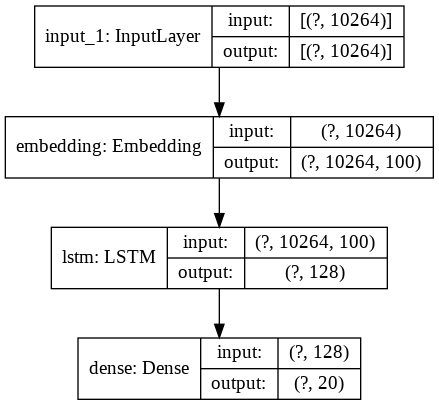

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='LSTM_model.png', show_shapes=True, show_layer_names=True)

# 6. Conclusive Analysis

## 6.1 Model Evaluation

In [ ]:
print("Logistic ROC:",logistic_auc_roc)
print("SVM ROC:",svm_auc_roc)
print("Random Forest ROC:", rf_auc_roc)
print("LSTM Model ROC:", lstm_auc_roc)

print("<------------------->")
print("Logistic ACC:", lr_acc)
print("SVM ACC:", svm_acc)
print("Random Forest ACC:", rf_acc)
print("LSTM Model ACC:", lstm_accuracy)

Logistic ROC: 0.5179840778823559
SVM ROC: 0.563356145710423
Random Forest ROC: 0.5312697926755738
LSTM Model ROC: 0.8121892213821411
<------------------->
Logistic ACC: 0.03377265238879736
SVM ACC: 0.13344316309719934
Random Forest ACC: 0.07495881383855024
LSTM Model ACC: 0.2796288728713989


## 6.2 Empirical Analysis

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
from sklearn import metrics
print(np.shape(model.predict(X_test[0])))

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
print(model.predict(X_test[1].reshape(1,200)))
print( y_test[1])# 8 10 12
print(movie_X_test.iloc[1,:].values)

(200, 20)
[[0.09573761 0.31568086 0.49610856 0.06380299 0.15229973 0.0152373
  0.0823833  0.3939131  0.09560096 0.130404   0.00559196 0.12149453
  0.02855173 0.05733404 0.05989337 0.01027381 0.11614025 0.01051795
  0.03299049 0.01041427]]
[0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0]
['Conducting a study on the psychology of incarceration, a Stanford professor assigns guard and prisoner roles to 24 male test subjects in a mock jail.']


## 6.3 Final Analysis

Post Questions

1. What type of analysis do we want to run on the dataset? 

  We ran classification algorithms on the dataset.

2. Will all features in the dataset be used?

  We did not include all the features in our final classification model. We used“Listed_in” as labels and “description” as features.
3. Given text data type, how do we process those data for our model? Which one is more effective?

  We tried 3 different methods (Count, Hash, Tfid) to process our data. Among all three methods, Tfid turned out to be the best method for our tasks.
5. What models should we use? How do we compare the performance of different models?

  We created three models for the dataset. The first one we built is logistic regression, the second one is random forest, and the third is LSTM Neural Network. After constructing the models, we used roc-auc scores to compare models, and CNN was our best model.


In the course of our analysis, many new questions follow with the completion of model construction and EDA. Diving into EDA, we noticed the unbalanced distribution of TV and movie data. The team decided to pursue only movie categories because the significant difference is beyond repair with available sampling techniques, such as SMOTE (Over-sampling and clean up with under-sampling). We first attempted traditional machine learning techniques and applied One vs. All concepts to perform multi-label classifications. We chose logistic regression, random forest, and SVM as our base models; Among options, SVM had the best average performance. 


Despite swapping different vectorizer methods, all traditional models had poor results in both accuracy score and ROC-AUC. Therefore, the team decided to carry out a better technique - LSTM Neural Network. The Neural Network was built with Keras and Sklearn, and we chose the built-in tokenizer and pad-sequence to process our text data. Yet, the performances still have not met the expectation, which is an 80% threshold. 
Later, we introduced the GloVe (Global Vectors for Word Presentation) to boost the significance of certain popular words. We chose the 100d Wikipedia 2014 + Gigaword 5 global dataset and added the processed corpus into the first embedding layer. 


The model’s performance had a significant improvement but was bothered by the unbalanced weights of big genres, such as International Movies, Comedies, and Dramas. We took a step further to manually adjust the weights of each genre so that small genres can have more impacts on labeling. Eventually, we constructed a model with a more than 80% ROC score and proved that Neural networks typically had stronger performance than traditional machine learning techniques when handling complex tasks.
